In [20]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

## 数据集准备 notMNIST

这个`jupyter notebook`整体实现了对`notMNNST`数据集的下载（被墙），可视化，分为训练、测试、验证集，并简单地实现了一个LR的分类器

- 检测dataset的图片，此处检查了训练集A中的十张图片

In [21]:
from os import listdir
from os.path import isfile, join
filedir = './notMNIST_large/A/'
imgFile = [f for f in listdir(filedir) if isfile(join(filedir, f))]

for i in range(10):
    display(Image(filename = filedir + imgFile[i]))

- 得到数据集的目录信息

In [51]:
train_folder = './notMNIST_large'
test_folder = './notMNIST_small'
train_folders = [join(train_folder, f) for f in listdir(train_folder) if not isfile(join(train_folder, f))]
train_folders.sort()
print(train_folders)
test_folders = [join(test_folder, f) for f in listdir(test_folder) if not isfile(join(test_folder, f))]
test_folders.sort()
print(test_folders)

['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


- 将图片信息归化到 `[-1, 1]`，并将每个标签的图片存储为PICKLE格式，并且记录下压缩文件目录

In [53]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling ./notMNIST_large/A.pickle.
./notMNIST_large/A
Could not read: ./notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : cannot identify image file './notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png' - it's ok, skipping.
Could not read: ./notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file './notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png' - it's ok, skipping.
Could not read: ./notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file './notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png' - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.12825
Standard deviation: 0.44312
Pickling ./notMNIST_large/B.pickle.
./notMNIST_large/B
Could not read: ./notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file './notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png' - it's ok, skipping.
Full dataset tensor: (52911, 28, 28)
Mean: -0.00756305
Standard deviation: 0.454491
Pickli

- 随机选择一个压缩目录，检查归一化后的图片效果

./notMNIST_large/C.pickle


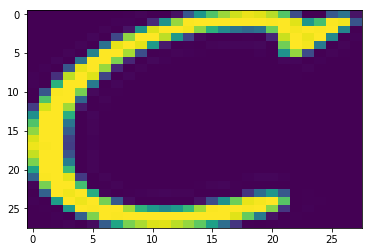

In [54]:
def load_dataset(pickle_name):
    with open(pickle_name, 'rb') as f:
        data = pickle.load(f)
    return data
    
print(train_datasets[2])
test = load_dataset(train_datasets[2])
plt.imshow(test[10], aspect='auto')
plt.show()

- 检查每个标签数据的数量

In [55]:
for trains in train_datasets:
    print(trains)
    print(load_dataset(trains).shape)
    
for tests in test_datasets:
    print(tests)
    print(load_dataset(tests).shape)

./notMNIST_large/A.pickle
(52909, 28, 28)
./notMNIST_large/B.pickle
(52911, 28, 28)
./notMNIST_large/C.pickle
(52912, 28, 28)
./notMNIST_large/D.pickle
(52911, 28, 28)
./notMNIST_large/E.pickle
(52912, 28, 28)
./notMNIST_large/F.pickle
(52912, 28, 28)
./notMNIST_large/G.pickle
(52912, 28, 28)
./notMNIST_large/H.pickle
(52912, 28, 28)
./notMNIST_large/I.pickle
(52912, 28, 28)
./notMNIST_large/J.pickle
(52911, 28, 28)
./notMNIST_small/A.pickle
(1872, 28, 28)
./notMNIST_small/B.pickle
(1873, 28, 28)
./notMNIST_small/C.pickle
(1873, 28, 28)
./notMNIST_small/D.pickle
(1873, 28, 28)
./notMNIST_small/E.pickle
(1873, 28, 28)
./notMNIST_small/F.pickle
(1872, 28, 28)
./notMNIST_small/G.pickle
(1872, 28, 28)
./notMNIST_small/H.pickle
(1872, 28, 28)
./notMNIST_small/I.pickle
(1872, 28, 28)
./notMNIST_small/J.pickle
(1872, 28, 28)


- 从`large`中选出`train`和`valid`数据集，从`small`中选出`test`数据集
- 每个标签内部进行shuffle

In [56]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


- `train`, `valid`, `test`内部打乱重排

In [58]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


- 三类数据集存储为一个PICKLE文件

In [62]:
data_root = '.'
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800506


- 用`scikit-learn`完成的LR实现

In [ ]:
logreg = LogisticRegression(C=1e5)

print(train_dataset.shape)
train_dataset = train_dataset.reshape(len(train_labels), image_size * image_size)
print(train_dataset.shape)
# we create an instance of Neighbours Classifier and fit the data.
logreg.fit(train_dataset, train_labels)

- 用分类器对测试集和验证集进行预测

In [82]:
valid_dataset = valid_dataset.reshape(len(valid_labels), image_size * image_size)
test_dataset = test_dataset.reshape(len(test_labels), image_size * image_size)

valid_predict = logreg.predict(valid_dataset)
print('accuracny on validation dataset %s ' % str(sum(valid_predict == valid_labels)/len(valid_labels)))
test_predict = logreg.predict(test_dataset)
print('accurancy on test dataset %s ' % str(sum(test_predict == test_labels)/len(test_labels)))

accuracny on validation dataset 0.8221 
accurancy on test dataset 0.8904 
